In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from lightgbm import LGBMClassifier
import optuna
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, log_loss
from sklearn.model_selection import StratifiedKFold, train_test_split
from lightgbm import early_stopping, log_evaluation
import joblib

## Loading the data

In [2]:
user_data = pl.read_csv('./data/Users.csv').with_columns(
    pl.col('install_date').cast(pl.Date),
    pl.col('registration_date').cast(pl.Date),
)
streamers_data = pl.read_csv('./data/Streamers.csv').with_columns(
    pl.col('install_date').cast(pl.Date),
    pl.col('registration_date').cast(pl.Date),
)
interations = pl.read_csv('./data/Users’ Activity.csv').with_columns(
    pl.col('date').cast(pl.Date),
    pl.col('timestamp').str.to_datetime('%Y-%m-%d %H:%M:%S'),
    pl.col('coins_spent_on_gift').cast(pl.UInt32)
)

## EDA

### Users activity data

In [3]:
interations.head()

date,timestamp,userId,streamerId,event,streamId,coins_spent_on_gift
date,datetime[μs],str,str,str,str,u32
2022-10-02,2022-10-02 16:46:33,"""62699531cbde3a0d5bfa5bd4""","""61f95f64a2f894c483b71574""","""user started to follow streame…","""non-stream""",null
2022-10-02,2022-10-01 23:59:30,"""63316b6dd177d176c106053f""","""62b0e29c7a0cc5d5c05367b1""","""user opened stream""","""6338ce2a08aa4f2581acba95""",null
2022-10-02,2022-10-01 23:59:30,"""6338263c94c9c82f2a49af21""","""6294544403012045e03a768a""","""user opened stream""","""6338ce2094c9c82f2a49e15b""",null
2022-10-02,2022-10-02 00:00:03,"""6296e20803012003b83b7a70""","""6336ec7230b4f027e73af54b""","""user closed stream""","""6338d42494c9c82f2a49e2c1""",null
2022-10-02,2022-10-01 23:59:33,"""63137235f613be54f9b6ca86""","""6294544403012045e03a768a""","""user opened stream""","""6338ce2094c9c82f2a49e15b""",null


In [4]:
interations.describe()

statistic,date,timestamp,userId,streamerId,event,streamId,coins_spent_on_gift
str,str,str,str,str,str,str,f64
"""count""","""922921""","""922921""","""922921""","""922920""","""922921""","""922921""",2600.0
"""null_count""","""0""","""0""","""0""","""1""","""0""","""0""",920321.0
"""mean""","""2022-10-02 01:44:39.748000""","""2022-10-02 14:50:29.342434""",null,null,null,null,130.315
"""std""",null,null,null,null,null,null,539.724705
"""min""","""2022-10-01""","""2022-09-30 23:59:30""","""61e92d1daed80b2fc820b79a""","""61e531e7b404e82b80cf4de5""","""user closed stream""","""6337762494c9c82f2a49834d""",0.0
"""25%""","""2022-10-01""","""2022-10-01 20:27:35""",null,null,null,null,0.0
"""50%""","""2022-10-02""","""2022-10-02 17:21:32""",null,null,null,null,7.0
"""75%""","""2022-10-03""","""2022-10-03 09:54:48""",null,null,null,null,99.0
"""max""","""2022-10-03""","""2022-10-03 23:59:58""","""635dd19e43a7b445bb5cf5c8""","""635bc71b64dd6fa90a9ddf93""","""user started to follow streame…","""non-stream""",17999.0


In [5]:
interations['event'].value_counts()

event,count
str,u32
"""user opened stream""",417764
"""user sent gift""",2600
"""user closed stream""",438583
"""user started to follow streame…",63974


In [6]:
interations['coins_spent_on_gift'].value_counts().sort('count', descending=True)

coins_spent_on_gift,count
u32,u32
null,920321
0,767
7,549
99,506
39,234
…,…
599,3
2999,2
1599,2


shape: (4, 2)
┌─────────────────────────────────┬────────┐
│ event                           ┆ count  │
│ ---                             ┆ ---    │
│ str                             ┆ u32    │
╞═════════════════════════════════╪════════╡
│ user started to follow streame… ┆ 63974  │
│ user sent gift                  ┆ 2600   │
│ user opened stream              ┆ 417764 │
│ user closed stream              ┆ 438583 │
└─────────────────────────────────┴────────┘


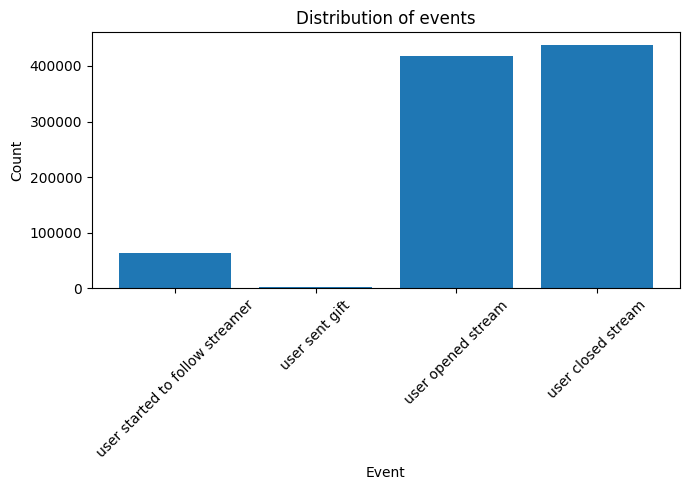

In [7]:
# let's analyze the distribution of different events
event_counts = interations['event'].value_counts()

print(event_counts)

plt.figure(figsize=(7, 5))
plt.bar(event_counts['event'], event_counts['count'])
plt.title('Distribution of events')
plt.xlabel('Event')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

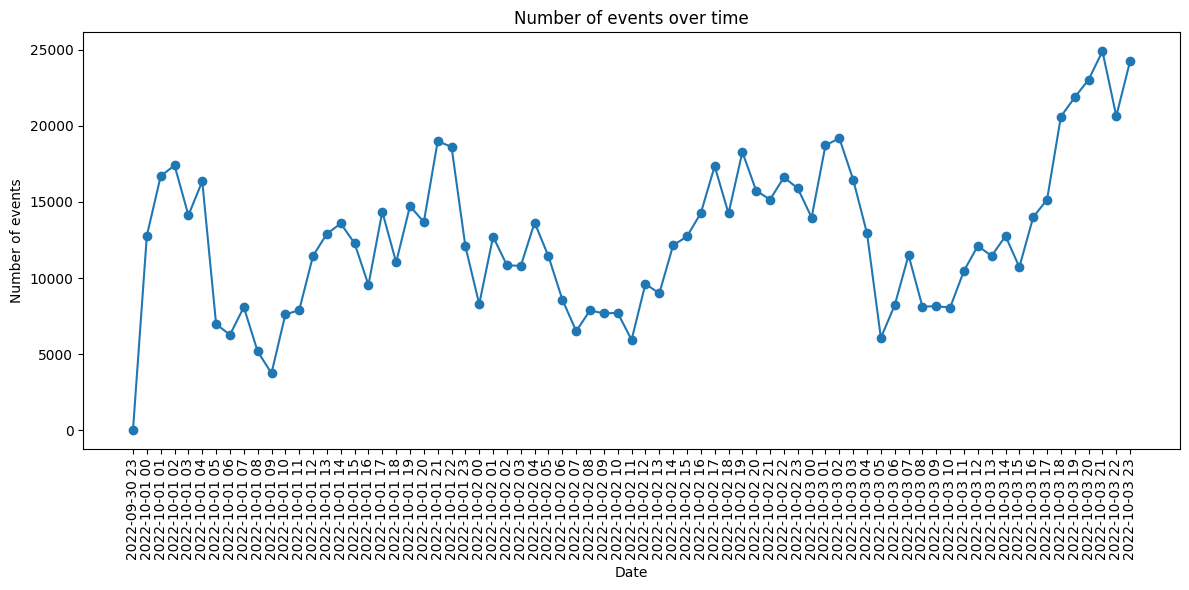

In [8]:
# let's see how events are distributed over time
events_over_time = interations.group_by(
    pl.col('timestamp').dt.strftime('%Y-%m-%d %H')
).len().sort('timestamp')

plt.figure(figsize=(12, 6))
plt.plot(events_over_time['timestamp'], events_over_time['len'], marker='o')
plt.title('Number of events over time')
plt.xlabel('Date')
plt.ylabel('Number of events')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

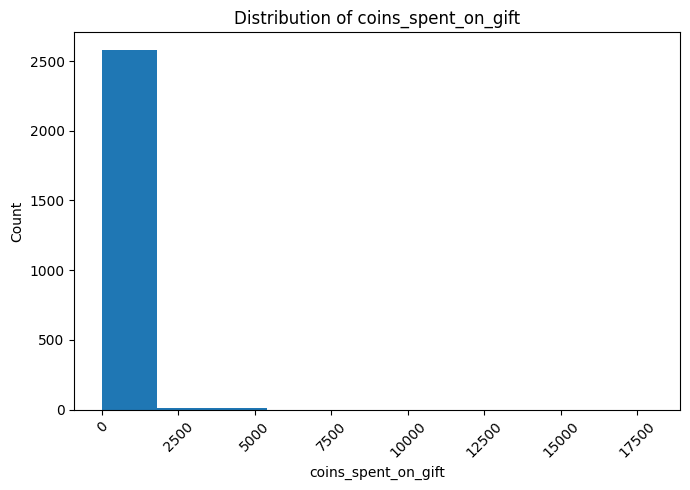

In [9]:
# let's analyze coins_spent_on_gift now

plt.figure(figsize=(7, 5))
plt.hist(interations['coins_spent_on_gift'])
plt.title('Distribution of coins_spent_on_gift')
plt.xlabel('coins_spent_on_gift')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
interations['coins_spent_on_gift'].describe()

statistic,value
str,f64
"""count""",2600.0
"""null_count""",920321.0
"""mean""",130.315
"""std""",539.724705
"""min""",0.0
"""25%""",0.0
"""50%""",7.0
"""75%""",99.0
"""max""",17999.0


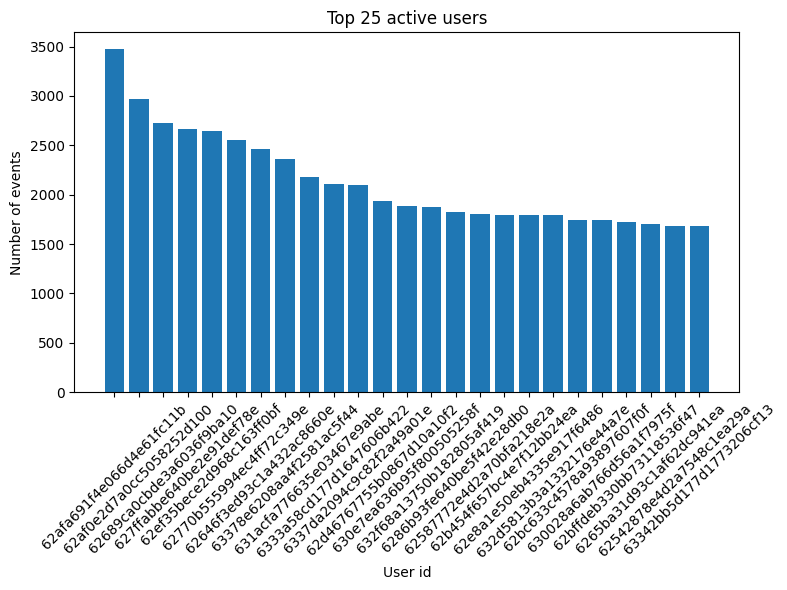

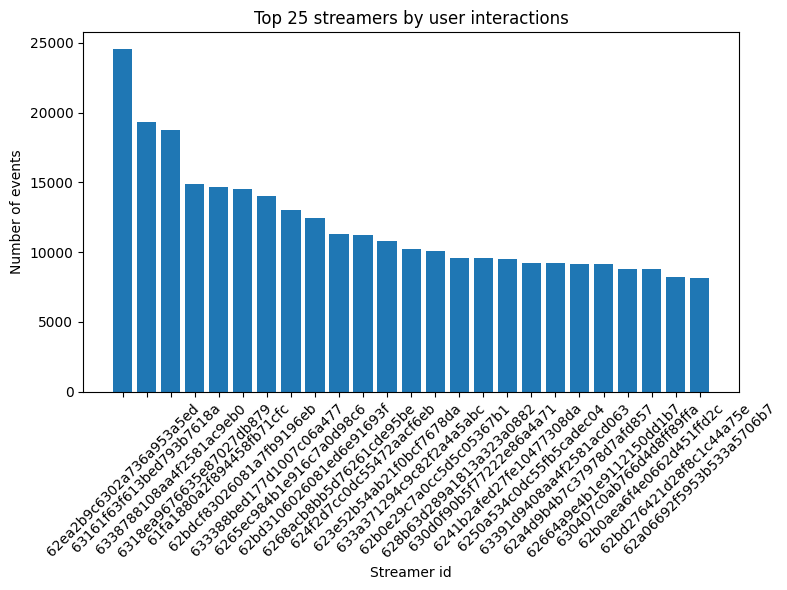

In [11]:
# now let's find out top users and streamers
# top active users
top_users = interations.group_by('userId').len().sort('len', descending=True).head(25)

plt.figure(figsize=(8, 6))
plt.bar(top_users['userId'], top_users['len'])
plt.title('Top 25 active users')
plt.xlabel('User id')
plt.ylabel('Number of events')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# top active streamers
top_streamers = interations.group_by('streamerId').len().sort('len', descending=True).head(25)

plt.figure(figsize=(8, 6))
plt.bar(top_streamers['streamerId'], top_streamers['len'])
plt.title('Top 25 streamers by user interactions')
plt.xlabel('Streamer id')
plt.ylabel('Number of events')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Users data

In [12]:
user_data.head()

userId,install_date,registration_date,gender,followings,media_source
str,date,date,str,i64,str
"""633b273f94c9c82f2a4a935e""",2022-10-03,2022-10-03,"""iPreferNotToSay""",null,"""Organic"""
"""6331463d3750b151715b8bca""",2022-09-26,2022-09-26,"""iPreferNotToSay""",20,"""bytedanceglobal_int"""
"""6339b3f708aa4f2581acf38e""",2022-10-02,2022-10-02,"""iPreferNotToSay""",null,"""Organic"""
"""63399a5508aa4f2581acecf5""",2022-10-02,null,"""iPreferNotToSay""",null,"""Organic"""
"""6337b7b194c9c82f2a499725""",2022-10-01,2022-10-08,"""iPreferNotToSay""",null,"""Organic"""


In [13]:
user_data.describe()

statistic,userId,install_date,registration_date,gender,followings,media_source
str,str,str,str,str,f64,str
"""count""","""10395""","""10395""","""8180""","""10395""",5044.0,"""10395"""
"""null_count""","""0""","""0""","""2215""","""0""",5351.0,"""0"""
"""mean""",null,"""2022-08-22 23:56:57.142000""","""2022-08-31 07:04:46.943000""",null,296.925852,null
"""std""",null,null,null,null,862.46062,null
"""min""","""61e92d1daed80b2fc820b79a""","""2022-01-20""","""2022-02-03""","""female""",1.0,"""Facebook Ads"""
"""25%""",null,"""2022-07-06""","""2022-07-15""",null,12.0,null
"""50%""",null,"""2022-09-29""","""2022-10-01""",null,28.0,null
"""75%""",null,"""2022-10-02""","""2022-10-02""",null,190.0,null
"""max""","""635dd19e43a7b445bb5cf5c8""","""2022-10-30""","""2023-05-07""","""male""",18891.0,"""snapchat_int"""


shape: (3, 2)
┌─────────────────┬───────┐
│ gender          ┆ count │
│ ---             ┆ ---   │
│ str             ┆ u32   │
╞═════════════════╪═══════╡
│ iPreferNotToSay ┆ 6121  │
│ female          ┆ 873   │
│ male            ┆ 3401  │
└─────────────────┴───────┘


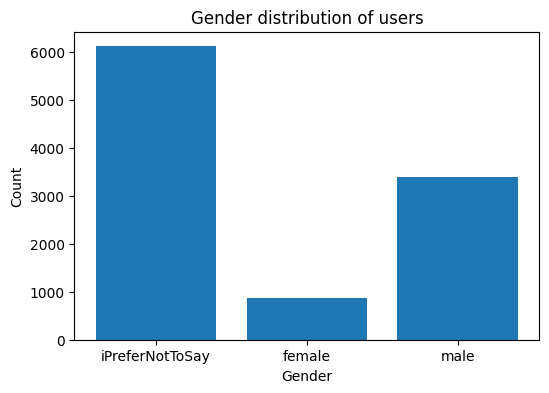

In [14]:
# let's see distribution of genders
gender_counts_users = user_data['gender'].value_counts()
print(gender_counts_users)

plt.figure(figsize=(6, 4))
plt.bar(gender_counts_users['gender'], gender_counts_users['count'])
plt.title('Gender distribution of users')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

shape: (6, 2)
┌─────────────────────┬───────┐
│ media_source        ┆ count │
│ ---                 ┆ ---   │
│ str                 ┆ u32   │
╞═════════════════════╪═══════╡
│ Organic             ┆ 6949  │
│ snapchat_int        ┆ 55    │
│ Facebook Ads        ┆ 1198  │
│ bytedanceglobal_int ┆ 1477  │
│ restricted          ┆ 164   │
│ googleadwords_int   ┆ 552   │
└─────────────────────┴───────┘


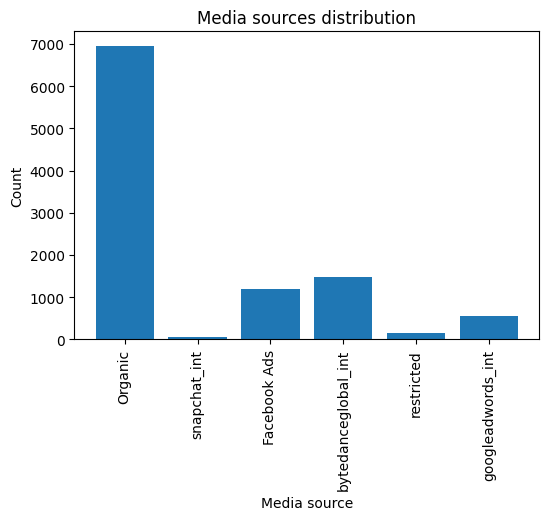

In [15]:
# media source distribution
media_source_distribution = user_data['media_source'].value_counts()
print(media_source_distribution)

plt.figure(figsize=(6, 4))
plt.bar(media_source_distribution['media_source'], media_source_distribution['count'])
plt.title('Media sources distribution')
plt.xlabel('Media source')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

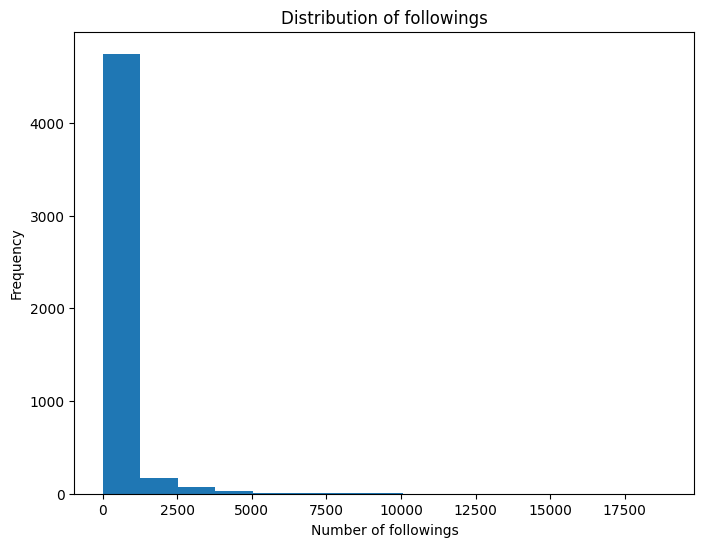

In [16]:
plt.figure(figsize=(8, 6))
plt.hist(user_data['followings'], bins=15)
plt.title('Distribution of followings')
plt.xlabel('Number of followings')
plt.ylabel('Frequency')
plt.show()

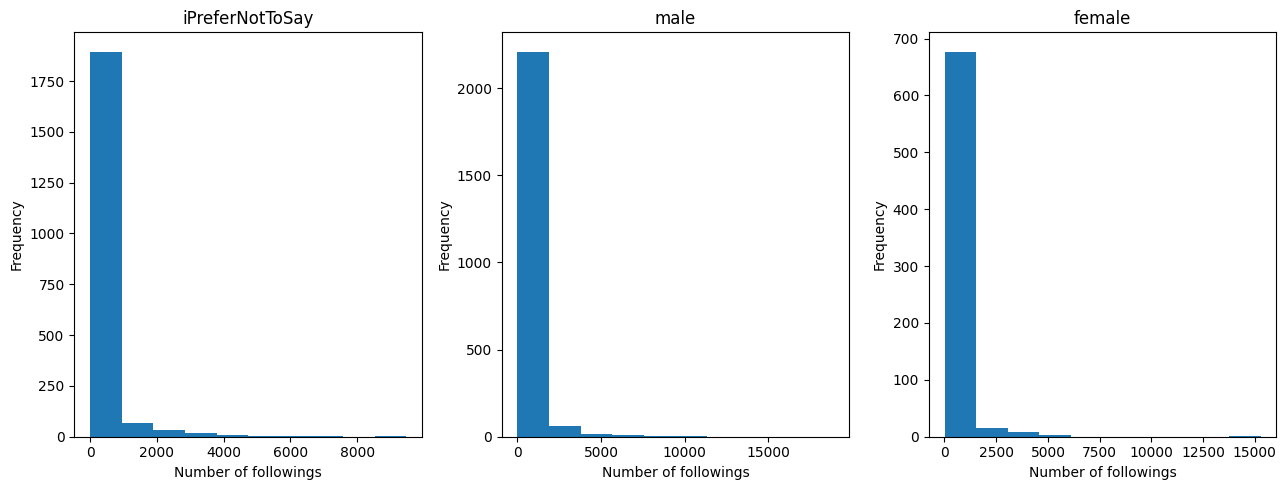

In [17]:
fig, axs = plt.subplots(1, user_data['gender'].n_unique(), figsize=(13, 5))

for ((gender,), gender_sample), ax in zip(user_data.group_by('gender'), axs.flatten()):
    ax.hist(gender_sample['followings'])
    ax.set_title(gender)
    ax.set_xlabel('Number of followings')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

The distributions of folowings between genders are more or less the same.

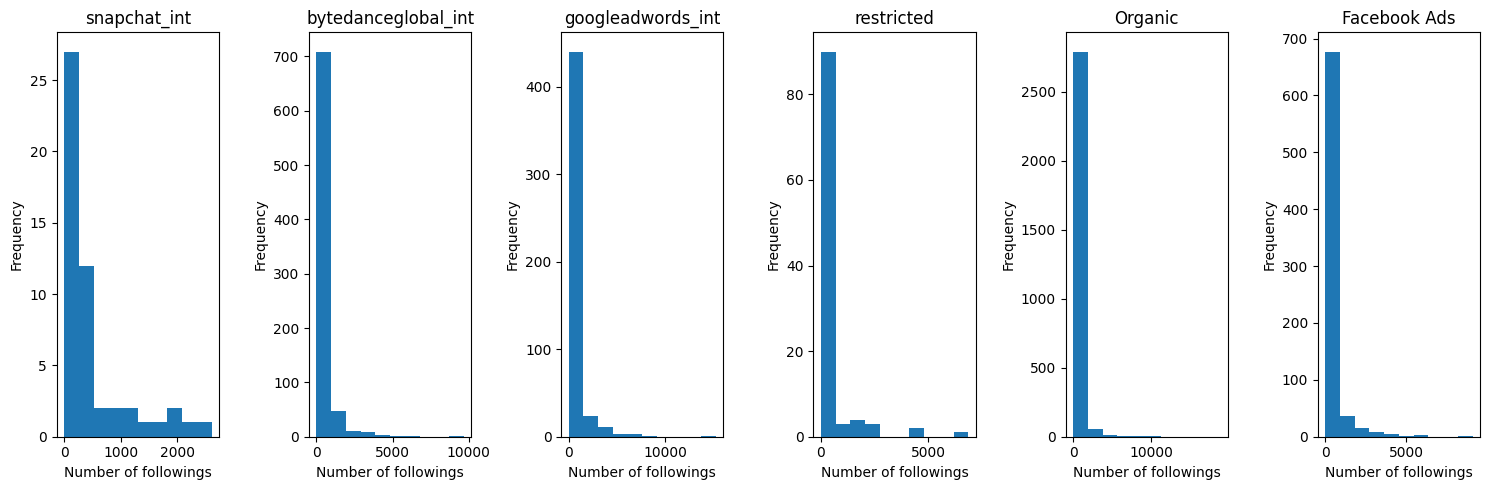

In [18]:
fig, axs = plt.subplots(1, user_data['media_source'].n_unique(), figsize=(15, 5))

for ((source,), source_sample), ax in zip(user_data.group_by('media_source'), axs.flatten()):
    ax.hist(source_sample['followings'])
    ax.set_title(source)
    ax.set_xlabel('Number of followings')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

We can see that users from snapchat media_source tend to have more followings than others.

### Streamers data

shape: (3, 2)
┌─────────────────┬───────┐
│ gender          ┆ count │
│ ---             ┆ ---   │
│ str             ┆ u32   │
╞═════════════════╪═══════╡
│ female          ┆ 449   │
│ iPreferNotToSay ┆ 352   │
│ male            ┆ 423   │
└─────────────────┴───────┘


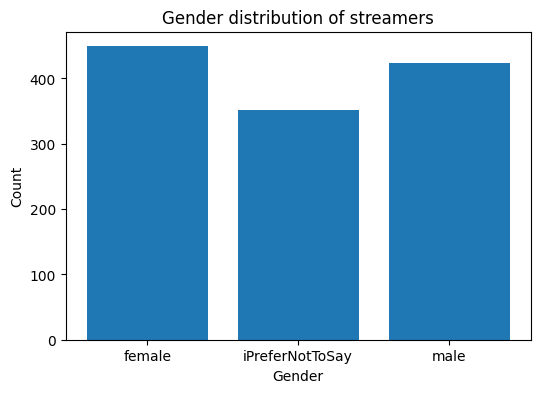

In [19]:
# let's see distribution of genders
gender_counts_users = streamers_data['gender'].value_counts()
print(gender_counts_users)

plt.figure(figsize=(6, 4))
plt.bar(gender_counts_users['gender'], gender_counts_users['count'])
plt.title('Gender distribution of streamers')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

shape: (2, 2)
┌───────────────┬───────┐
│ streamer_type ┆ count │
│ ---           ┆ ---   │
│ str           ┆ u32   │
╞═══════════════╪═══════╡
│ Individual    ┆ 1018  │
│ Official      ┆ 206   │
└───────────────┴───────┘


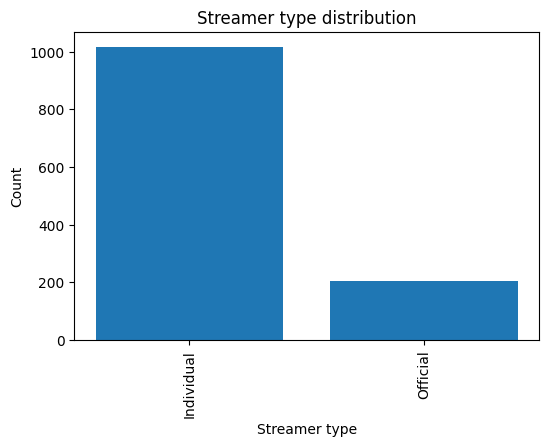

In [20]:
# streamer type distribution
streamer_types = streamers_data['streamer_type'].value_counts()
print(streamer_types)

plt.figure(figsize=(6, 4))
plt.bar(streamer_types['streamer_type'], streamer_types['count'])
plt.title('Streamer type distribution')
plt.xlabel('Streamer type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

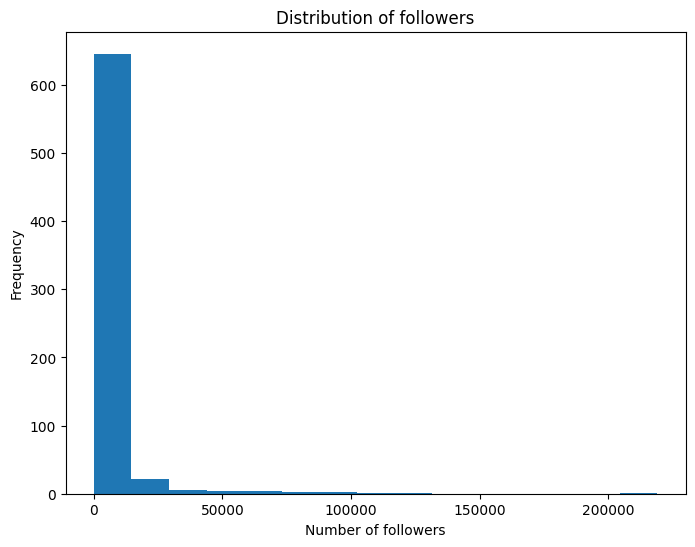

In [21]:
plt.figure(figsize=(8, 6))
plt.hist(streamers_data['followers'], bins=15)
plt.title('Distribution of followers')
plt.xlabel('Number of followers')
plt.ylabel('Frequency')
plt.show()

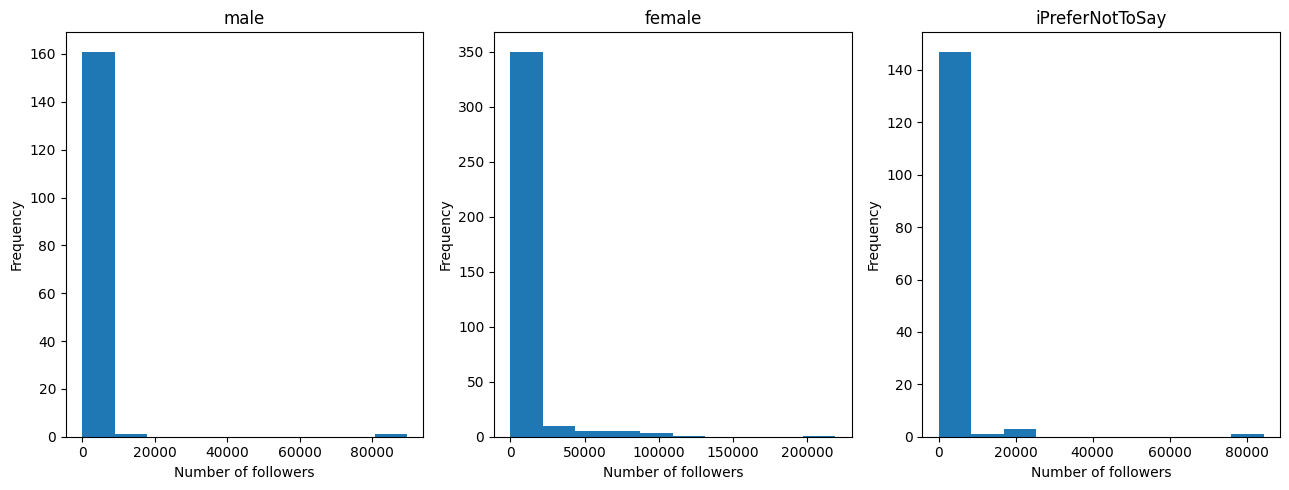

In [22]:
fig, axs = plt.subplots(1, streamers_data['gender'].n_unique(), figsize=(13, 5))

for ((gender,), gender_sample), ax in zip(streamers_data.group_by('gender'), axs.flatten()):
    ax.hist(gender_sample['followers'])
    ax.set_title(gender)
    ax.set_xlabel('Number of followers')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

From the plot above we can see that female streamer followers distribution has more heavy tail to the right. This means that female streamers are more likely to get more followers than other genders.

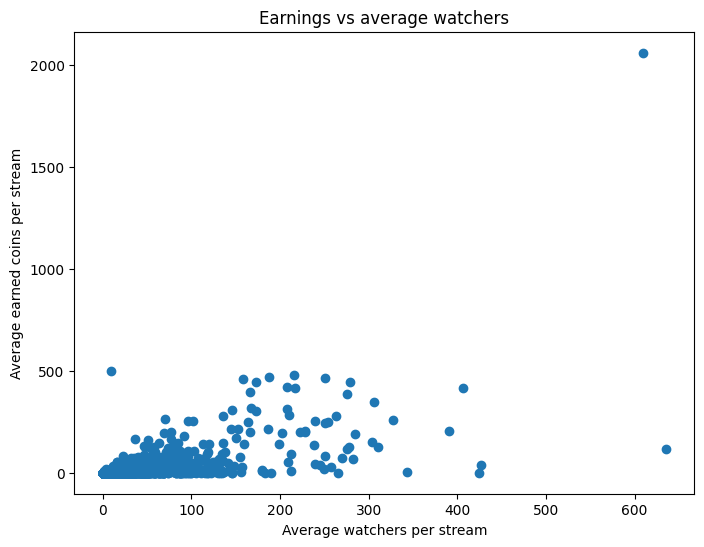

In [23]:
# let's see streamer performance plot

plt.figure(figsize=(8, 6))
plt.scatter(streamers_data['avg_watchers_per_stream'], streamers_data['avg_earned_coins_per_stream'])
plt.title('Earnings vs average watchers')
plt.xlabel('Average watchers per stream')
plt.ylabel('Average earned coins per stream')
plt.show()

In [24]:
streamers_data.select('avg_watchers_per_stream', 'avg_earned_coins_per_stream').corr()

avg_watchers_per_stream,avg_earned_coins_per_stream
f64,f64
1.0,0.608308
0.608308,1.0


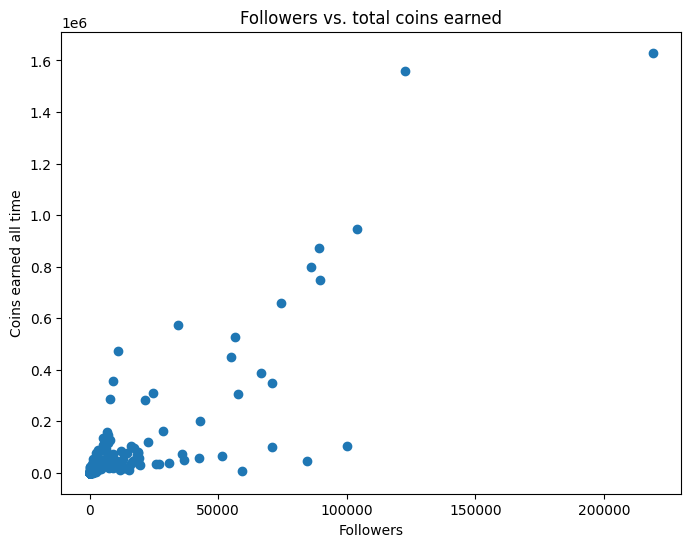

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(streamers_data['followers'], streamers_data['coins_earned_all_time'])
plt.title('Followers vs. total coins earned')
plt.xlabel('Followers')
plt.ylabel('Coins earned all time')
plt.show()

In [26]:
streamers_data.select('followers', 'coins_earned_all_time').drop_nulls().corr()

followers,coins_earned_all_time
f64,f64
1.0,0.858956
0.858956,1.0


We can clearly see a correlation between streamer performance and earnings. Possibly a small research could be established to segment streamers based on their performance.

### Combined analysis

In [27]:
interactions_users_df = interations.join(user_data, on='userId', how='left')

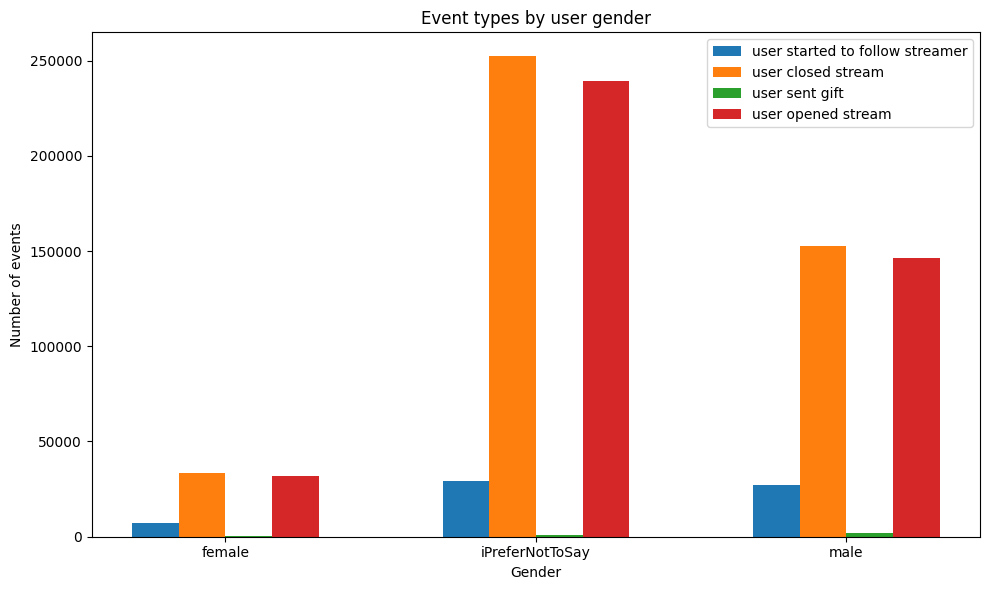

In [28]:
# let's see distribution of events by user gender

event_gender_counts = interactions_users_df.group_by('gender', 'event').len().pivot(
    index='gender', on='event', values='len'
)

genders = event_gender_counts['gender']
event_columns = event_gender_counts.columns[1:]  # exclude 'gender'
data = [event_gender_counts[col].to_list() for col in event_columns]

x = np.arange(len(genders))
width = 0.15 
fig, ax = plt.subplots(figsize=(10, 6))
for i, (event, counts) in enumerate(zip(event_columns, data)):
    ax.bar(x + i * width, counts, width, label=event)

ax.set_xticks(x + width * (len(event_columns) - 1) / 2)
ax.set_xticklabels(genders)
ax.set_xlabel('Gender')
ax.set_ylabel('Number of events')
ax.set_title('Event types by user gender')
ax.legend()
plt.tight_layout()
plt.show()

The distributions of events across different gender groups are likely the same. This indicates that gender cannot be effectively used as a criterion for segmenting users.

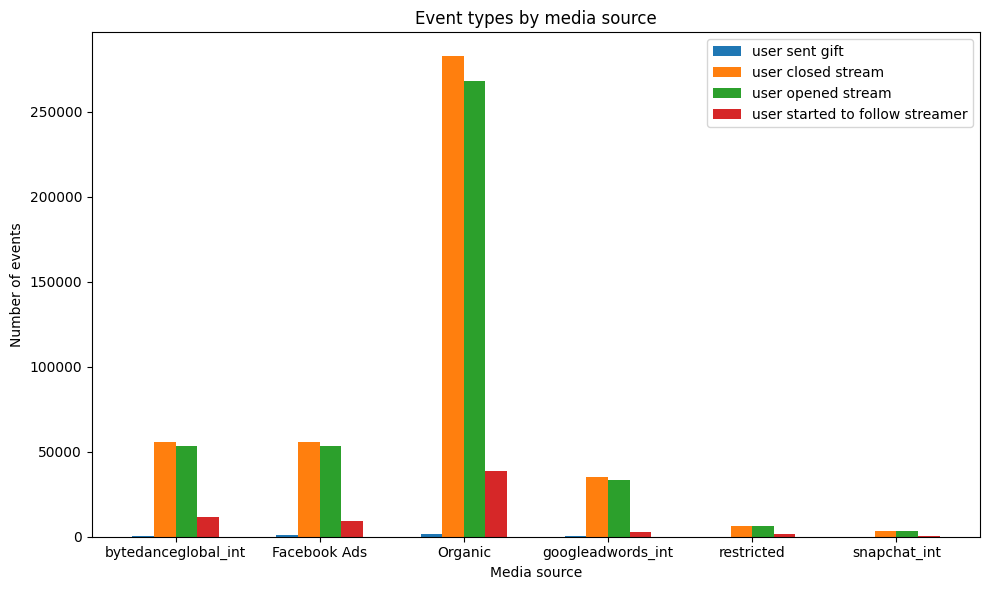

In [29]:
event_media_counts = interactions_users_df.group_by('media_source', 'event').len().pivot(
    index='media_source', on='event', values='len'
)
media_sources = event_media_counts['media_source']
event_columns = event_media_counts.columns[1:]  # exclude 'media_source'
data = [event_media_counts[col].to_list() for col in event_columns]

x = np.arange(len(media_sources))
width = 0.15 
fig, ax = plt.subplots(figsize=(10, 6))
for i, (event, counts) in enumerate(zip(event_columns, data)):
    ax.bar(x + i * width, counts, width, label=event)

ax.set_xticks(x + width * (len(event_columns) - 1) / 2)
ax.set_xticklabels(media_sources)
ax.set_xlabel('Media source')
ax.set_ylabel('Number of events')
ax.set_title('Event types by media source')
ax.legend()
plt.tight_layout()
plt.show()

We observe that the distributions are generally similar. However, users from Organic sources tend to follow streamers slightly more frequently.

In [30]:
# now let's see interactions from streamer perspective
interaction_streamers_df = interations.join(
    streamers_data.rename({'gender': 'gender_streamer'}), on='streamerId', how='left'
)

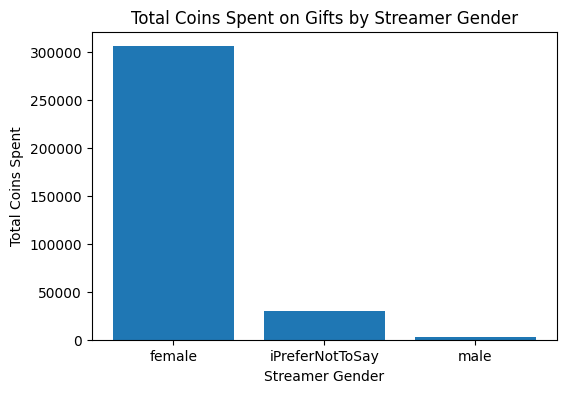

In [31]:
# gifts sent to streamers by his gender
gift_data = interaction_streamers_df.filter(pl.col('event') == 'user sent gift')

gifts_by_streamer_gender = gift_data.group_by('gender_streamer').agg(
    pl.col('coins_spent_on_gift').sum().alias('total_coins_spent')
)

plt.figure(figsize=(6, 4))
plt.bar(
    gifts_by_streamer_gender['gender_streamer'], 
    gifts_by_streamer_gender['total_coins_spent'], 
)
plt.title('Total Coins Spent on Gifts by Streamer Gender')
plt.xlabel('Streamer Gender')
plt.ylabel('Total Coins Spent')
plt.show()

- It is evident that most coins are received by female streamers. This information could be valuable for the user segmentation process.
- P.S. Further analysis of the combined data could provide deeper insights. For now, we will focus solely on basic analytics.

## User Segmentation (for analysis)

- From the insights above, we can conclude that the diversity in the data allows us to segment both users and streamers effectively.
- For now, we will focus on simple user segmentation due to time constraints. However, further analysis could be conducted to better cluster users and streamers.

In [32]:
# for now, I will perform segmentation solely to gain insights from user profiles.
# the approach will involve a simple K-means clustering, after which I will interpret the resulting clusters.
# in a real pipeline, it would be necessary to incorporate additional user features and employ more 
# sophisticated algorithms, such as multi-class classification using LightGBM models. 
# this would allow for recommending items within clusters, 
# optimizing the time required for generating recommendations.
# however, due to time constraints, as previously mentioned, I will
# build a straightforward algorithm focused purely on analytical purposes
# for understanding user profiles.

# using some feature engineering to improve K-means clusterization
user_activity = interations.group_by('userId').agg([
    pl.len().alias('total_events'),
    pl.col('coins_spent_on_gift').sum().alias('total_coins_spent'),
    pl.col('streamerId').n_unique().alias('unique_streamers')
])

In [33]:
user_features = user_activity.join(
    user_data.select(['userId', 'gender', 'followings', 'media_source']), on='userId', how='left'
)
user_features.head()

userId,total_events,total_coins_spent,unique_streamers,gender,followings,media_source
str,u32,u32,u32,str,i64,str
"""627ffabbe640be2e91def78e""",2663,0,138,"""female""",624,"""Organic"""
"""6338c49a08aa4f2581acb799""",73,0,29,"""iPreferNotToSay""",null,"""Organic"""
"""63339701d177d14b4406af99""",1088,0,139,"""iPreferNotToSay""",null,"""Organic"""
"""632282be76635e0b87814935""",40,0,10,"""iPreferNotToSay""",null,"""bytedanceglobal_int"""
"""633953ef94c9c82f2a4a15bf""",39,0,16,"""male""",null,"""Organic"""


In [34]:
user_features = user_features.with_columns(
    pl.col('followings').fill_null(0)
)

In [35]:
# encoding features
gender_encoder = LabelEncoder()
gender_encoded = gender_encoder.fit_transform(user_features['gender'])

media_source_encoder = OneHotEncoder(handle_unknown='ignore')
media_source_encoded = media_source_encoder.fit_transform(user_features[['media_source']]).toarray()
media_source_features = media_source_encoder.get_feature_names_out().tolist()

media_source_encoded = pl.DataFrame(media_source_encoded, schema=media_source_features)

user_features_enc = user_features.with_columns(
    pl.Series('gender_encoded', values=gender_encoded)
)

user_features_enc = pl.concat([user_features_enc, media_source_encoded], how='horizontal')

# select features for clustering
features = user_features_enc.select([
    'total_events',
    'total_coins_spent',
    'unique_streamers',
    'followings',
    'gender_encoded',
    *media_source_features
])
features.head()

total_events,total_coins_spent,unique_streamers,followings,gender_encoded,media_source_Facebook Ads,media_source_Organic,media_source_bytedanceglobal_int,media_source_googleadwords_int,media_source_restricted,media_source_snapchat_int
u32,u32,u32,i64,i64,f64,f64,f64,f64,f64,f64
2663,0,138,624,0,0.0,1.0,0.0,0.0,0.0,0.0
73,0,29,0,1,0.0,1.0,0.0,0.0,0.0,0.0
1088,0,139,0,1,0.0,1.0,0.0,0.0,0.0,0.0
40,0,10,0,1,0.0,0.0,1.0,0.0,0.0,0.0
39,0,16,0,2,0.0,1.0,0.0,0.0,0.0,0.0


In [36]:
# scaling the features to normalize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

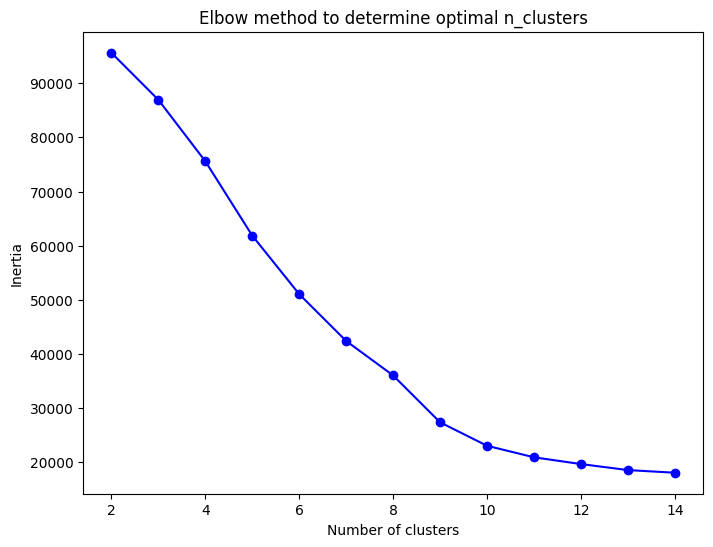

In [37]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


inertia = []
n_clusters = list(range(2, 15))
for k in n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=54)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)


# plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(n_clusters, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method to determine optimal n_clusters')
plt.show()

We can see that optimal number of user clusters is 10.

In [38]:
kmeans = KMeans(n_clusters=10, random_state=54)
labels = kmeans.fit_predict(features_scaled)


user_features_enc = user_features_enc.with_columns(
    pl.Series(name='cluster', values=labels)
)

In [39]:
# let's visualize obtained user clusters
# for these purposes PCA will be utlized

from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=3, random_state=54)
principal_components = pca.fit_transform(features_scaled)

user_features_enc = user_features_enc.with_columns(
    pl.Series('PC1', principal_components[:, 0]),
    pl.Series('PC2', principal_components[:, 1]),
    pl.Series('PC3', principal_components[:, 2])
)


fig = px.scatter_3d(
    user_features_enc,
    x='PC1',
    y='PC2',
    z='PC3',
    color='cluster',
    hover_data=['total_events', 'total_coins_spent', 'unique_streamers', 'followings'],
    title='3D Visualization of Clusters',
    labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'PC3': 'Principal Component 3'}
)

fig.show()

As we can see, the clustering algorithm has grouped the users; however, the separation is not particularly clear in the 3D space. Let’s delve into some statistics to better understand the clusters.

In [40]:
user_features_enc.group_by('cluster').agg(
    pl.col('total_events').mean(),
    pl.col('total_coins_spent').mean(),
    pl.col('unique_streamers').mean(),

    pl.col('gender').mode(),
    pl.col('followings').mean(),
    pl.col('media_source').mode()
).sort('cluster')

cluster,total_events,total_coins_spent,unique_streamers,gender,followings,media_source
i32,f64,f64,f64,list[str],f64,list[str]
0,786.07177,104.610048,120.191388,"[""iPreferNotToSay""]",361.992823,"[""Organic""]"
1,45.26776,2.714633,14.195102,"[""iPreferNotToSay""]",41.092896,"[""Organic""]"
2,57.978903,13.40647,18.107595,"[""iPreferNotToSay""]",95.478903,"[""bytedanceglobal_int""]"
3,59.864437,58.043134,17.637324,"[""male""]",131.984155,"[""Facebook Ads""]"
4,59.667885,39.946374,18.499086,"[""male""]",116.698964,"[""Organic""]"
5,103.766603,25.751423,25.246679,"[""male""]",277.210626,"[""googleadwords_int""]"
6,70.093168,13.84472,21.186335,"[""iPreferNotToSay""]",144.73913,"[""restricted""]"
7,121.818182,131.545455,28.181818,"[""male""]",423.709091,"[""snapchat_int""]"
8,146.5,54038.5,29.0,"[""iPreferNotToSay"", ""male""]",548.5,"[""Organic""]"


Let's interpret obtained clusters.
- Cluster 4 (Very high spenders with moderate activity)
	- Exceptional spending, moderate activity, high followings.
	- Strategy: offer VIP experiences, personalized services, and exclusive content.
- Clusters: 3, 7 (High activity and high spend)
	- Very active, significant spenders, high followings.
	- Strategy: maintain engagement with new features, challenges, and community events.
- Cluster 9 (High activity, low Spend)
	- Highly active, minimal spending, vast followings.
	- Strategy: monetize through ads, stimulate first-time purchases with promotions.
- Clusters: 2, 5, 6 (Moderate activity and spend)
	- Steady activity, willing to spend, responsive to marketing.
	- Strategy: upsell with bundle offers, loyalty programs, and personalized recommendations.
- Clusters: 0, 1, 8 (Casual users, low activity, low spend)
	- Low to moderate activity, minimal spending, possibly new users.
	- Strategy: improve onboarding, highlight key features, and encourage engagement with tutorials and tips.
- Clusters: 1, 3, 8 (Privacy-conscious users)
	- unspecified gender, possibly reluctant to share personal info.
	- Strategy: emphasize privacy policies, ensure trustworthiness, and avoid intrusive marketing.

Also based on this baseline clustering, we can observe patterns in user data that may help define rules for more effective segmentation. Here are some insights:

- Data shows that certain clusters are predominantly associated with specific media_source values (e.g., 'snapchat_int', 'googleadwords_int'). This indicates that media_source is a discriminative feature and can be used to segment users effectively.
-	The data also reveals that many clusters have 'Organic' as the most common media_source. Since this group is large and diverse, further segmentation is necessary to understand and target these users better.
-	By combining media_source with activity metrics like total_events or followings, we can create more granular clusters.

- Next steps could include conducting further analysis to determine the optimal way to segment 'Organic' users based on activity metrics and applying more performant clustering algorithms using the proposed features (for example media_source and total_events) to create the baseline segmentation.

## Feature engineering & lgbm recomendation model

- Having explored the data and identified common user profiles, we can now proceed to build a recommendation pipeline.
- While user segments won’t be utilized due to time constraints, in a real-world scenario, accurately segmenting users and creating tailored models for each segment would be an excellent approach. This would help optimize processing time and enhance overall model performance.
- I propose treating the recommendation problem as a supervised classification task and building recommendations using the LightGBM algorithm.
- Additionally, it would be beneficial to experiment with alternative architectures. For instance, building collaborative filtering on data subsamples or leveraging deep learning by implementing a DeepFM model could further improve the system.

In [41]:
# let's start with dataset preparation and feature engineering
# the idea is to encode events such that more significant events are assigned higher values
event_weights = {
    'user opened stream': 2,
    'user closed stream': 1,
    'user started to follow streamer': 6,
    'user sent gift': 8
}

positive_pairs = interations.with_columns(
    pl.col('event').replace_strict(event_weights),
    pl.col('coins_spent_on_gift').fill_null(0)
).drop('date', 'streamId', 'timestamp')
positive_pairs.head()

userId,streamerId,event,coins_spent_on_gift
str,str,i64,u32
"""62699531cbde3a0d5bfa5bd4""","""61f95f64a2f894c483b71574""",6,0
"""63316b6dd177d176c106053f""","""62b0e29c7a0cc5d5c05367b1""",2,0
"""6338263c94c9c82f2a49af21""","""6294544403012045e03a768a""",2,0
"""6296e20803012003b83b7a70""","""6336ec7230b4f027e73af54b""",1,0
"""63137235f613be54f9b6ca86""","""6294544403012045e03a768a""",2,0


In [42]:
# sample negative cases (when event did not occured)
unique_users = pl.DataFrame(user_data['userId'].unique())
unique_streamers = pl.DataFrame(streamers_data['streamerId'].unique())
all_pairs = unique_users.join(unique_streamers, how='cross')
pp = interations.select('userId', 'streamerId')
negative_pairs = all_pairs.join(pp, on=['userId', 'streamerId'], how='anti').sample(n=len(interations))
negative_pairs = negative_pairs.with_columns(
    pl.lit(0).alias('event'),
    pl.lit(None).alias('timestamp'),
    pl.lit(0).alias('coins_spent_on_gift')
).select(*positive_pairs.columns)
negative_pairs.head()

userId,streamerId,event,coins_spent_on_gift
str,str,i32,i32
"""62fd37a5ab766d47baf6bbc5""","""6338477b94c9c82f2a49b80d""",0,0
"""62cf39410e91c2e5d2672a74""","""633856bd08aa4f2581ac9401""",0,0
"""6334eb4638c52fb3346e778e""","""6338219108aa4f2581ac857a""",0,0
"""6339decc08aa4f2581ad0255""","""631724d8f613be77feb7af02""",0,0
"""6276a72406a26664ba4272a4""","""633a6d4108aa4f2581ad35fd""",0,0


In [43]:
all_pairs = pl.concat([positive_pairs, negative_pairs], how='vertical_relaxed')

In [44]:
# build some datetime features to capture data seasonality
engineered_user_data = user_data.with_columns(
    pl.col('install_date').dt.weekday().alias('user_install_weekday'),
    pl.col('install_date').dt.month().alias('user_install_month'),
    (pl.col('registration_date') == pl.col('install_date')).alias('user_registered_same_day'),
).drop('install_date', 'registration_date')

engineered_streamer_data = streamers_data.with_columns(
    pl.col('registration_date').dt.month().alias('streamer_registered_month'),
    pl.col('registration_date').dt.week().alias('streamer_registered_week'),
    (pl.col('install_date') == pl.col('registration_date')).alias('stremer_registered_same_day'),
).drop('install_date', 'registration_date')


In [45]:
all_pairs = all_pairs.join(engineered_user_data, on='userId')
all_pairs = all_pairs.join(engineered_streamer_data, on='streamerId', suffix='_streamer')

In [46]:
# let's encode dataframe columns
oh_encoder = OneHotEncoder()

features_to_encode = ['gender', 'media_source', 'gender_streamer', 'streamer_type']
transformed = oh_encoder.fit_transform(all_pairs[features_to_encode])
transformed = pl.DataFrame(transformed.toarray(), schema=oh_encoder.get_feature_names_out().tolist()).with_columns(
    pl.all().cast(pl.Int8)
)

all_pairs_encoded = pl.concat([all_pairs.drop(features_to_encode), transformed], how='horizontal')

In [47]:
all_pairs_data = all_pairs_encoded.drop('userId', 'streamerId')

In [48]:
# I will use the event as the target variable for the multiclass classification.
# the idea is to train a multiclass classifier that, based on user parameters, 
# predicts the probabilities of possible events for a user.
# if the event = 0, it indicates no interaction. In other cases, we will leverage 
# the model’s output to generate recommendations for the user.


X_train, X_test, y_train, y_test, all_pairs_train, all_pairs_test = train_test_split(
    all_pairs_data.drop('event'), 
    all_pairs_data['event'], 
    all_pairs_encoded,
    shuffle=True, 
    stratify=all_pairs['event'],
    random_state=54
)

In [ ]:
# I will utilize optuna for seaching hyperparameters

def objective(trial: optuna.Trial):
    param_grid = {
        'objective': 'multiclass',
        'num_class': 4,
        'metric': 'multi_logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, step=0.01),
        'num_leaves': trial.suggest_int('num_leaves', 50, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 30),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000, step=100),
    }
    
    kf = StratifiedKFold(n_splits=5)
    cv_scores = []
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        model = LGBMClassifier(**param_grid, verbosity=-1)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='multi_logloss',
            callbacks=[
                early_stopping(stopping_rounds=50),
                log_evaluation(50)
            ]
        )
    
        y_pred_prob = model.predict_proba(X_val)
        loss = log_loss(y_val, y_pred_prob)
        cv_scores.append(loss)
    
    return np.mean(cv_scores)

In [52]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3)

[I 2024-11-29 01:18:03,877] A new study created in memory with name: no-name-2be1fc21-bfb1-497e-903d-357bc4da21f0


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.696379
[100]	valid_0's multi_logloss: 0.666428
[150]	valid_0's multi_logloss: 0.655527
[200]	valid_0's multi_logloss: 0.650332
[250]	valid_0's multi_logloss: 0.6471
[300]	valid_0's multi_logloss: 0.645052
[350]	valid_0's multi_logloss: 0.643117
[400]	valid_0's multi_logloss: 0.641599
[450]	valid_0's multi_logloss: 0.640328
[500]	valid_0's multi_logloss: 0.639227
Did not meet early stopping. Best iteration is:
[500]	valid_0's multi_logloss: 0.639227
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.695477
[100]	valid_0's multi_logloss: 0.665529
[150]	valid_0's multi_logloss: 0.654665
[200]	valid_0's multi_logloss: 0.649034
[250]	valid_0's multi_logloss: 0.645469
[300]	valid_0's multi_logloss: 0.643203
[350]	valid_0's multi_logloss: 0.640834
[400]	valid_0's multi_logloss: 0.639215
[450]	valid_0's multi_logloss: 0.637812
[500]	valid_0's multi_logloss: 0.6

[I 2024-11-29 01:28:13,718] Trial 0 finished with value: 0.6377795310361483 and parameters: {'learning_rate': 0.04, 'num_leaves': 146, 'max_depth': 16, 'min_child_samples': 8, 'min_child_weight': 0.09876023816952004, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.13854560605889737, 'reg_lambda': 0.005024432503793589, 'n_estimators': 500}. Best is trial 0 with value: 0.6377795310361483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.72159
[100]	valid_0's multi_logloss: 0.680409
[150]	valid_0's multi_logloss: 0.666294
[200]	valid_0's multi_logloss: 0.658573
[250]	valid_0's multi_logloss: 0.653845
[300]	valid_0's multi_logloss: 0.650723
[350]	valid_0's multi_logloss: 0.648285
[400]	valid_0's multi_logloss: 0.646455
[450]	valid_0's multi_logloss: 0.644806
[500]	valid_0's multi_logloss: 0.643476
[550]	valid_0's multi_logloss: 0.642382
[600]	valid_0's multi_logloss: 0.641458
[650]	valid_0's multi_logloss: 0.640694
[700]	valid_0's multi_logloss: 0.640082
Did not meet early stopping. Best iteration is:
[700]	valid_0's multi_logloss: 0.640082
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.720483
[100]	valid_0's multi_logloss: 0.679572
[150]	valid_0's multi_logloss: 0.665651
[200]	valid_0's multi_logloss: 0.657668
[250]	valid_0's multi_logloss: 0.652921
[300]	valid_0's multi_logloss: 0.

[I 2024-11-29 01:40:52,601] Trial 1 finished with value: 0.6394438088804314 and parameters: {'learning_rate': 0.03, 'num_leaves': 119, 'max_depth': 14, 'min_child_samples': 8, 'min_child_weight': 0.8653559512539369, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_alpha': 0.0035283781131979206, 'reg_lambda': 0.012566684541467754, 'n_estimators': 700}. Best is trial 0 with value: 0.6377795310361483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.694915
[100]	valid_0's multi_logloss: 0.676978
[150]	valid_0's multi_logloss: 0.667775
[200]	valid_0's multi_logloss: 0.661099
[250]	valid_0's multi_logloss: 0.657232
[300]	valid_0's multi_logloss: 0.653279
[350]	valid_0's multi_logloss: 0.65106
[400]	valid_0's multi_logloss: 0.648978
[450]	valid_0's multi_logloss: 0.647164
[500]	valid_0's multi_logloss: 0.64563
[550]	valid_0's multi_logloss: 0.644418
[600]	valid_0's multi_logloss: 0.643432
[650]	valid_0's multi_logloss: 0.642517
[700]	valid_0's multi_logloss: 0.641849
[750]	valid_0's multi_logloss: 0.640966
[800]	valid_0's multi_logloss: 0.640545
Did not meet early stopping. Best iteration is:
[800]	valid_0's multi_logloss: 0.640545
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.693468
[100]	valid_0's multi_logloss: 0.675952
[150]	valid_0's multi_logloss: 0.667133
[200]	valid_0's multi_logloss: 0.6

[I 2024-11-29 01:49:12,079] Trial 2 finished with value: 0.6401648201436261 and parameters: {'learning_rate': 0.06999999999999999, 'num_leaves': 54, 'max_depth': 7, 'min_child_samples': 16, 'min_child_weight': 1.2266554478609752, 'subsample': 0.9, 'colsample_bytree': 1.0, 'reg_alpha': 0.055586525149569625, 'reg_lambda': 0.03858492892019096, 'n_estimators': 800}. Best is trial 0 with value: 0.6377795310361483.


In [53]:
model = LGBMClassifier(**study.best_params, verbosity=-1)
model.fit(
    X_train, y_train,
    eval_metric='multi_logloss',
    callbacks=[
        log_evaluation(50)
    ]
)

LGBMClassifier(learning_rate=0.04, max_depth=16, min_child_samples=8,
               min_child_weight=0.09876023816952004, n_estimators=500,
               num_leaves=146, reg_alpha=0.13854560605889737,
               reg_lambda=0.005024432503793589, subsample=0.8, verbosity=-1)

In [55]:
pl.Config.set_tbl_rows(20)
pl.DataFrame({
    'feature': X_train.columns, 
    'importance': model.feature_importances_
}).sort('importance', descending=True).head(20)

feature,importance
str,i32
"""followings""",99207
"""followers""",36774
"""user_install_weekday""",35776
"""avg_watchers_per_stream""",32362
"""user_install_month""",30944
"""avg_stream_duration""",29593
"""coins_earned_all_time""",18517
"""avg_earned_coins_per_stream""",18237
"""streamer_registered_week""",11412


In [56]:
test_proba = model.predict_proba(X_test)
roc_auc_score(y_test, test_proba, multi_class='ovr')

np.float64(0.8977914476377336)

In [57]:
test_predict = model.predict(X_test)
f1_score(y_test, test_predict, average='weighted')

np.float64(0.6574974796797959)

In [58]:
precision_score(y_test, test_predict, average='weighted')

np.float64(0.6644467271643085)

In [59]:
recall_score(y_test, test_predict, average='weighted')

np.float64(0.6760860011052561)

So, as we can see, we have obtained some training metrics. While these metrics are not particularly strong, further adjustments and tuning are possible, potentially including feature engineering. Due to time constraints, I cannot implement this now, but it would be beneficial to calculate some aggregation metrics for users, streamers, and streams. For example:
-	The number of interactions per user for each event type.
-	Similarly, the number of interactions per streamer.

In [60]:
def prepare_predict_dataset(user_id: str) -> pl.DataFrame:
    all_streamers_not_interacted = pl.DataFrame(all_pairs.filter(pl.col('userId') != user_id)['streamerId'].unique())
    target_user_data = engineered_user_data.filter(pl.col('userId') == user_id)
    target_user_data = target_user_data.select(pl.all().repeat_by(len(all_streamers_not_interacted)).flatten())
    predict_data = pl.concat([all_streamers_not_interacted, target_user_data], how='horizontal')
    predict_data = predict_data.join(engineered_streamer_data, on='streamerId', suffix='_streamer')
    transformed = oh_encoder.transform(predict_data[features_to_encode])
    transformed = pl.DataFrame(transformed.toarray(), schema=oh_encoder.get_feature_names_out().tolist()).with_columns(
        pl.all().cast(pl.Int8)
    )
    predict_data = pl.concat([predict_data.drop(features_to_encode), transformed], how='horizontal')
    return predict_data.drop('userId').with_columns(pl.lit(0).alias('coins_spent_on_gift'))

In [61]:
def rank_candidates(prediction_dataset: pl.DataFrame) -> pl.DataFrame:
    y_prob = model.predict_proba(prediction_dataset.drop('streamerId'))
    weighted_probs = y_prob * model.classes_
    recommendation_scores = weighted_probs.sum(axis=1)
    return pl.DataFrame({
        'streamerId': prediction_dataset['streamerId'],
        'recomendation_score': recommendation_scores
    }).sort('recomendation_score', descending=True)

In [62]:
prediction_dataset = prepare_predict_dataset('6324823df4d17a98fc302e9d')
prediction_dataset.head()

streamerId,followings,user_install_weekday,user_install_month,user_registered_same_day,followers,coins_earned_all_time,avg_stream_duration,avg_watchers_per_stream,avg_earned_coins_per_stream,streamer_registered_month,streamer_registered_week,stremer_registered_same_day,gender_female,gender_iPreferNotToSay,gender_male,media_source_Facebook Ads,media_source_Organic,media_source_bytedanceglobal_int,media_source_googleadwords_int,media_source_restricted,media_source_snapchat_int,gender_streamer_female,gender_streamer_iPreferNotToSay,gender_streamer_male,streamer_type_Individual,streamer_type_Official,coins_spent_on_gift
str,i64,i8,i8,bool,i64,i64,f64,f64,f64,i8,i8,bool,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i32
"""62e317f9a51fb840278916c3""",1,5,9,false,26,0,2.0,20.0,0.0,7,30,true,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0
"""6334d09b38c52fb3346e72c3""",1,5,9,false,162,104,7.26,66.42,5.47,9,39,true,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
"""6308c0f4ab766d90dff98a34""",1,5,9,false,2570,4784,3.0,69.7,11.51,8,34,true,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0
"""6338952f08aa4f2581aca7fc""",1,5,9,false,7,0,1.0,26.0,0.0,10,39,true,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
"""633785e808aa4f2581ac5cf8""",1,5,9,false,null,0,1.0,7.0,0.0,10,39,true,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0


In [63]:
rank_candidates(prediction_dataset)

streamerId,recomendation_score
str,f64
"""6339806208aa4f2581ace672""",7.999599
"""6339849094c9c82f2a4a1fe9""",7.99956
"""6336d3f630b4f027e73af24a""",7.999557
"""632ca547db7721b170d58b3d""",7.999491
"""63380e7694c9c82f2a49a94a""",7.999479
"""63235ebbfafcf10d831db2c8""",7.999457
"""63172ec8f613be2d4eb7afd0""",7.99944
"""6336ec7230b4f027e73af54b""",7.999357
"""6339a2c608aa4f2581acef50""",7.999332


So, now we got a recommendation pipeline of streamers to users. Let's evaluate it

In [64]:
def compute_precision_at_k(recommended: list, relevant: list, k: int) -> float:
    if not relevant:
        return 0.0  # avoid division by zero
    recommended_at_k = recommended[:k]
    hits = len(set(recommended_at_k) & set(relevant))
    return hits / k

def compute_recall_at_k(recommended: list, relevant: list, k: int) -> float:
    if not relevant:
        return 0.0
    recommended_at_k = recommended[:k]
    hits = len(set(recommended_at_k) & set(relevant))
    return hits / len(relevant)

def compute_ndcg_at_k(recommended: list, relevant: list, k: int) -> float:
    dcg = 0.0
    for i, rec in enumerate(recommended[:k]):
        if rec in relevant:
            dcg += 1 / np.log2(i + 2)  # rank position starts at 1, so i + 2
    # ideal DCG (IDCG)
    idcg = 0.0
    ideal_hits = min(len(relevant), k)
    for i in range(ideal_hits):
        idcg += 1 / np.log2(i + 2)
    
    return dcg / idcg if idcg > 0 else 0.0

def compute_mrr(recommended: list, relevant: list) -> float:
    for rank, rec in enumerate(recommended, start=1):
        if rec in relevant:
            return 1 / rank
    return 0.0

In [65]:
def evaluate_rank_candidates(test_users: list, k: int) -> None:
    precisions = []
    recalls = []
    ndcgs = []
    mrrs = []
    for user_id in test_users:
        prediction_dataset = prepare_predict_dataset(user_id)
        ranked_candidates = rank_candidates(prediction_dataset)
        recommended_streamers = ranked_candidates['streamerId'][:k].to_list()
        relevant_streamers = all_pairs_test.filter(
            pl.col('userId') == user_id,
            pl.col('event') > 0
        ).select(pl.col('streamerId').unique())['streamerId'].to_list()
        precisions.append(compute_precision_at_k(recommended_streamers, relevant_streamers, k))
        recalls.append(compute_recall_at_k(recommended_streamers, relevant_streamers, k))
        ndcgs.append(compute_ndcg_at_k(recommended_streamers, relevant_streamers, k))
        mrrs.append(compute_mrr(recommended_streamers, relevant_streamers))
    
    print(f'Precision@{k}: {np.mean(precisions):.4f}')
    print(f'Recall@{k}: {np.mean(recalls):.4f}')
    print(f'NDCG@{k}: {np.mean(ndcgs):.4f}')
    print(f'MRR: {np.mean(mrrs):.4f}')

In [66]:
test_users = all_pairs_test['userId'].unique().sample(5000).to_list()

evaluate_rank_candidates(test_users, 100)

Precision@100: 0.0406
Recall@100: 0.3297
NDCG@100: 0.1341
MRR: 0.1096


The provided metrics can be interpreted as follows:
- Precision@100 (0.0406) - out of the top 100 recommendations, only about 4.06% are relevant. This suggests the system is not very precise and could benefit from better feature selection or modeling to improve the quality of top recommendations.
- Recall@100 (0.3297) - the system retrieves 33% of all relevant items for a user within the top 100 recommendations. While better than precision, this still indicates room for improvement in covering more of what the user considers relevant.
-	NDCG@100 (0.1341) - a score suggests the ranking order of the recommendations isn’t optimal, with relevant items not appearing at the top as frequently as desired.
-	MRR (0.1096) - the system is generally showing the first relevant item further down the ranking, reducing usability.

Due to limited time I had, significant model improvements aren’t feasible now. However, these steps could improve performance if prioritized in the future:
- Incorporate advanced features such as user-item interaction history, temporal dynamics, and contextual information to better represent the data.
- Experiment with collaborative filtering, including matrix factorization techniques, try to implement advanced models like DeepFM for combining feature interactions.
- Train models on specific user segments to capture diverse preferences and behaviors.

Such iterative improvements would likely boost precision, recall, and ranking performance metrics significantly.

The overall recommendation pipeline built so far serves as a solid starting point for developing a more advanced recommendation system.